In [1]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Flatten, Dense, Dropout
#from tensorflow.python.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
#from tensorflow.python.keras.applications.xception import xception, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.xception import decode_predictions, preprocess_input
from tensorflow.keras.layers import GlobalAvgPool2D
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report,confusion_matrix
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping

Using TensorFlow backend.


In [2]:
#DATASET_PATH  = './catsdogs/sample'
#IMAGE_SIZE    = (299, 299)
#NUM_CLASSES   = 2
#BATCH_SIZE    = 8  # try reducing batch size or freeze more layers if your GPU runs out of memory
FREEZE_LAYERS = 2  # freeze the first this many layers for training
#NUM_EPOCHS    = 20
#WEIGHTS_FINAL = 'model-inception_resnet_v2-final.h5'


img_width, img_height = 128,128 # make it bigger

train_data_dir = 'C:/Users/tevin/Collaborations\Habib - Haar - Tevin/Data/Cropped images/Draft1/Train'
test_data_dir = 'C:/Users/tevin/Collaborations\Habib - Haar - Tevin/Data/Cropped images/Draft1/Test'

#Go on a 8:20 spil
#267:67
nb_train_samples = 160
nb_test_samples = 40
epochs = 40
batch_size = 4



#train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
#                                   rotation_range=40,
#                                   width_shift_range=0.2,
#                                   height_shift_range=0.2,
#                                   shear_range=0.2,
#                                   zoom_range=0.2, must be there
#                                   channel_shift_range=10,
#                                   horizontal_flip=True, must be there
#                                   fill_mode='nearest')

#CONSIDER REMOVING PREPROCESS INPUT AND ADDING RESCALE BACK IN relook at hthe data augmentation
train_datagen = ImageDataGenerator(
        #preprocessing_function=preprocess_input,
        rescale=1. / 255,
        #horizontal_flip=True,
        shear_range=0.2, # remoce 
        zoom_range=0.2) 

    # this is the augmentation configuration we will use for testing:
    # only rescaling
test_datagen = ImageDataGenerator(
        #preprocessing_function=preprocess_input,
        rescale=1. / 255,
        #horizontal_flip=True,
        shear_range=0.2,
        zoom_range=0.2)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        #interpolation='bicubic',
        #shuffle=True,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
        #interpolation='bicubic',
        batch_size=batch_size,
        shuffle=False,
        class_mode='categorical')



Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [3]:


model = tf.keras.applications.xception.Xception(include_top=False, #try and enable
                        weights=None,#'imagenet', 
                        input_tensor=None,
                        input_shape=(img_width, img_height, 3))

#Ask if i am to add the glabal average pooling                          
x = model.output # remove all this
#add the average global layer 
#x = Flatten()(x)
#x = Dropout(0.5)(x)
x = GlobalAveragePooling2D()(x)
#do the global and then follow by a dense layer for binary classification x = Dense(1, activation='softmax')(x)

#x = Dense(2, activation='softmax')(x)
output_layer = Dense(2, activation='softmax', name='softmax')(x)
net_final = Model(inputs=model.input, outputs=output_layer)
#for layer in net_final.layers[:FREEZE_LAYERS]:
#    layer.trainable = False
#for layer in net_final.layers[FREEZE_LAYERS:]:
#    layer.trainable = True

net_final.summary()

# (4) Compile 
net_final.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

filepath="C:/Users/tevin/Collaborations/Habib - Haar - Tevin/Training/weights.Xception2.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
    
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')

history = net_final.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    validation_data=test_generator,
    validation_steps=nb_test_samples // batch_size,
    epochs=epochs,
    callbacks=[checkpoint,early])



Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 63, 63, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 63, 63, 32)   0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

Epoch 1/40
40/40 [==============================] - ETA: 0s - loss: 0.9992 - accuracy: 0.5750
Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to C:/Users/tevin/Collaborations/Habib - Haar - Tevin/Training\weights.Xception2.hdf5
40/40 [==============================] - 74s 2s/step - loss: 0.9992 - accuracy: 0.5750 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 2/40
40/40 [==============================] - ETA: 0s - loss: 0.5740 - accuracy: 0.7312
Epoch 00002: val_accuracy did not improve from 0.50000
40/40 [==============================] - 61s 2s/step - loss: 0.5740 - accuracy: 0.7312 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 3/40
40/40 [==============================] - ETA: 0s - loss: 0.4875 - accuracy: 0.7875
Epoch 00003: val_accuracy did not improve from 0.50000
40/40 [==============================] - 61s 2s/step - loss: 0.4875 - accuracy: 0.7875 - val_loss: 0.6950 - val_accuracy: 0.5000
Epoch 4/40
40/40 [==============================] - ETA: 0s - los

Epoch 29/40
40/40 [==============================] - ETA: 0s - loss: 0.0900 - accuracy: 0.9625
Epoch 00029: val_accuracy did not improve from 1.00000
40/40 [==============================] - 33s 823ms/step - loss: 0.0900 - accuracy: 0.9625 - val_loss: 1.9903 - val_accuracy: 0.7000
Epoch 30/40
40/40 [==============================] - ETA: 0s - loss: 0.3583 - accuracy: 0.8938
Epoch 00030: val_accuracy did not improve from 1.00000
40/40 [==============================] - 34s 845ms/step - loss: 0.3583 - accuracy: 0.8938 - val_loss: 68.2148 - val_accuracy: 0.5000
Epoch 31/40
40/40 [==============================] - ETA: 0s - loss: 0.2007 - accuracy: 0.9250
Epoch 00031: val_accuracy did not improve from 1.00000
40/40 [==============================] - 33s 821ms/step - loss: 0.2007 - accuracy: 0.9250 - val_loss: 10.2481 - val_accuracy: 0.5750
Epoch 32/40
40/40 [==============================] - ETA: 0s - loss: 0.1644 - accuracy: 0.9500
Epoch 00032: val_accuracy did not improve from 1.00000
40

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
[0.574999988079071, 0.731249988079071, 0.7875000238418579, 0.824999988079071, 0.8687499761581421, 0.800000011920929, 0.893750011920929, 0.862500011920929, 0.8999999761581421, 0.956250011920929, 0.949999988079071, 0.875, 0.949999988079071, 0.893750011920929, 0.9437500238418579, 0.9437500238418579, 0.856249988079071, 0.9312499761581421, 0.8999999761581421, 0.9312499761581421, 0.987500011920929, 0.987500011920929, 0.9937499761581421, 1.0, 1.0, 1.0, 1.0, 0.9937499761581421, 0.9624999761581421, 0.893750011920929, 0.925000011920929, 0.949999988079071, 0.9437500238418579, 0.925000011920929, 0.9624999761581421, 0.9312499761581421, 0.9437500238418579, 0.956250011920929, 0.987500011920929, 0.96875]


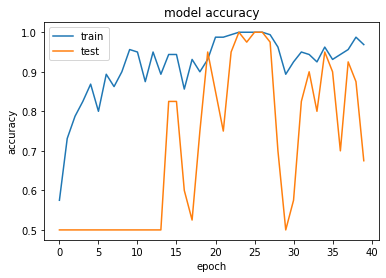

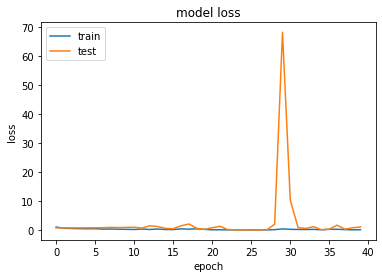

In [4]:
# list all data in history
#plt.figure(figsize=(15,8))

print(history.history.keys())
print(history.history['accuracy'])

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('C:/Users/tevin/Collaborations/Habib - Haar - Tevin/Results/Xception/Accuracy2.png')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('C:/Users/tevin/Collaborations/Habib - Haar - Tevin/Results/Xception/Loss2.png')
plt.show()

#loss, acc = model.evaluate_generator(test_generator, nb_test_samples // batch_size+1)
#print(acc * 100)
#print(loss * 100)

#take off shuiffle

In [9]:
from tensorflow import keras
from keras.models import load_model


model = keras.models.load_model('C:/Users/tevin/Collaborations/Habib - Haar - Tevin/Training/weights.Xception2.hdf5')

#model.load_weights("C:/Users/tevin/Collaborations/Habib - Haar - Tevin/Training/weights.Inception.hdf5")
# Compile model (required to make predictions)
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

print("Created model and loaded weights from file")


loss, accuracy = model.evaluate_generator(test_generator, nb_test_samples // batch_size, verbose=0)
print(accuracy)
print(loss)

Created model and loaded weights from file
0.9750000238418579
0.05671461299061775


Instructions for updating:
Please use Model.predict, which supports generators.
[[9.9961072e-01 3.8935681e-04]
 [9.7530502e-01 2.4694968e-02]
 [9.9890327e-01 1.0966982e-03]
 [9.6833760e-01 3.1662334e-02]
 [9.9999964e-01 4.1368600e-07]
 [9.9999070e-01 9.3023546e-06]
 [9.5491236e-01 4.5087609e-02]
 [9.9968624e-01 3.1377227e-04]
 [7.7424043e-01 2.2575957e-01]
 [9.9998236e-01 1.7587254e-05]
 [9.9990416e-01 9.5817741e-05]
 [8.1661659e-01 1.8338341e-01]
 [9.9996018e-01 3.9774943e-05]
 [9.9960488e-01 3.9519399e-04]
 [9.9998593e-01 1.4047208e-05]
 [9.9413741e-01 5.8625923e-03]
 [9.9337327e-01 6.6267429e-03]
 [4.8163816e-01 5.1836181e-01]
 [9.9998689e-01 1.3103769e-05]
 [9.9998891e-01 1.1065146e-05]
 [1.0833636e-02 9.8916644e-01]
 [5.6738206e-03 9.9432617e-01]
 [1.6036296e-03 9.9839634e-01]
 [6.6793803e-04 9.9933201e-01]
 [2.0560015e-03 9.9794394e-01]
 [2.2672841e-03 9.9773264e-01]
 [3.5492965e-05 9.9996448e-01]
 [1.5829308e-02 9.8417062e-01]
 [1.5825944e-03 9.9841738e-01]
 [8.1082649e-04 9.991

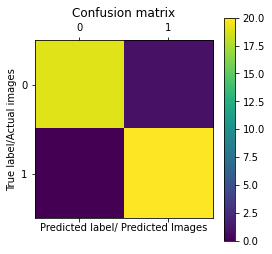

In [6]:
preds3 = model.predict_generator(test_generator, nb_test_samples // batch_size)
#print(test_generator.classes.shape)
#print(np.shape(preds3))
print(preds3)
prediction2 = np.argmax(preds3, axis=1)

print(preds3)

print('this is the predicted data')
print(prediction2)
print('this is the test data')
print(test_generator.classes)

print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, prediction2)
print(cm)


print('Classification Report')
#target_names = ['Noise','Strokes']
print(classification_report(test_generator.classes, prediction2))

plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label/Actual images')
plt.xlabel('Predicted label/ Predicted Images')
plt.savefig('C:/Users/tevin/Collaborations/Habib - Haar - Tevin/Results/Xception/Confusion2.png')
plt.show()